In [ ]:
!python -m pip install pydantic langchain langchain-community pdfplumber langchain-core langchain-openai langgraph faiss-cpu --quiet

In [29]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [3]:
embedding_model_name = "text-embedding-ada-002"
model_name = "gpt-4o-mini"

doc_paths = ["https://www.morningstar.com/content/dam/marketing/shared/research/methodology/771945_Morningstar_Rating_for_Funds_Methodology.pdf",
             "https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf",
             "https://s21.q4cdn.com/198919461/files/doc_downloads/press_kits/2016/Morningstar-Sustainable-Investing-Handbook.pdf"]

In [4]:
from langchain_openai import AzureOpenAIEmbeddings
embeddings = AzureOpenAIEmbeddings(model=embedding_model_name)


from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(model=model_name)


In [5]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loaders = [PyPDFLoader(pdf, extract_images=False) for pdf in doc_paths]
docs = []
for loader in loaders: docs.extend(loader.load())
docs = [doc for doc in docs if len(doc.page_content.strip())>100]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3500, chunk_overlap=500,
                                               add_start_index=True)
splits = text_splitter.split_documents(docs)


In [6]:
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings,collection_name="morningstar_docs")

# using vector db object to initialize a retriever object - to perform vector search/retrieval
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
from langchain_core.documents import Document

class cragstate(TypedDict):
    query: str
    answer: str
    context: List[Document]
    refined: bool
    grader_score: str
    updated_query_retrieval: str
    updated_query_web_search: str
    web_search:bool

## Grader Implementation

In [58]:
from pydantic import BaseModel, Field

class GraderInput(BaseModel):
    binary_score: str = Field(..., description="""The binary score indicating relevance, whether the retrived context is releant to 
                              answer the query, final answer should be only one word:  yes or no  """)

grader_llm = llm.with_structured_output(GraderInput)

# grader node

def grader_node(state: cragstate) -> cragstate:
    print("=======Grader check=======")

    context = "\n \n ".join([doc.page_content for doc in state['context']])
    prompt = f'''Given the user query and the retrieved context, determine if the context is relevant to answer the query.
    
    User Query: {state['query']}
    
    Retrieved Context: {context}
    Is the retrieved context relevant to answer the user query? Respond with 'yes' or 'no'.
    
    Consider below rubrics for evaluation:
    1. Relevance: Does the context directly address the user's query?
    2. Completeness: Does the context provide sufficient information to answer the query?
    3. Concept Specificity: Is the context specific to the topic of the query?
    4. Alignment: Does the context align with the intent of the user's question?


    Examples:
    Query: "What is the Morningstar Rating for Funds methodology?"
    Context: "The Morningstar Rating for Funds methodology evaluates mutual funds based on their risk-adjusted returns relative to their peers."
    Answer: "yes"

    Query: "Explain the concept fund ratings for by Fidelity and Edelweiss."
    Context: "The Morningstar Rating for Funds methodology evaluates mutual funds based on their risk-adjusted returns relative to their peers."
    Answer: "no" '''
    result = grader_llm.invoke(prompt)
    return {"grader_score": result.binary_score,"refined":state.get("refined")}


In [78]:
# retriever node
def retriever_node(state: cragstate) -> cragstate:
    
    refined = state['refined']

    if refined:
        print("=======Retriver with modified user query =======")
        query_to_use = state['updated_query_retrieval']
    else:
        print("=======Retriver with original query =======")
        query_to_use = state['query']
    retrieved_docs = retriever.get_relevant_documents(query_to_use)
    return {"context": retrieved_docs}

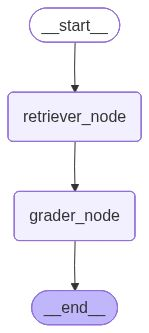

In [79]:
# creating a subgraph for retrieval and grading
builder1 = StateGraph(cragstate)
builder1.add_node(retriever_node)
builder1.add_node(grader_node)
builder1.add_edge(START, "retriever_node")
builder1.add_edge("retriever_node", "grader_node")

graph1 = builder1.compile()
graph1


In [80]:
graph1.invoke({"query": "What is the Morningstar Rating for Funds methodology?","refined": False,})

=======Retriver with original query =======
=======Grader check=======


{'query': 'What is the Morningstar Rating for Funds methodology?',
 'context': [Document(metadata={'page': 0, 'source': 'https://www.morningstar.com/content/dam/marketing/shared/research/methodology/771945_Morningstar_Rating_for_Funds_Methodology.pdf', 'start_index': 0}, page_content='The Morningstar RatingTM for Funds\nMorningstar Methodology\nAugust 2021\nContents\nIntroduction \nMorningstar Categories \nTheory \nCalculations \nThe Morningstar Rating: \nThree-, Five-, and 10-Year \nMorningstar Return and \nMorningstar Risk Rating\nThe Overall Morningstar Rating\nRating Suspensions\nConclusion\nAppendix 1: Risk-Free Rates Applied\nAppendix 2: Methodology Changes\nAppendix 3: Star Ratings for Separately\nManaged Accounts and Models\nImportant Disclosure\nMerged with the existing star rating\nThe conduct of Morningstar’s analysts is governed \nby Code of Ethics/Code of Conduct Policy, Personal \nSecurity Trading Policy (or an equivalent of), \nand Investment Research Policy. For informa

In [81]:
graph1.invoke({"query": "What is the language model?","refined": False,})

=======Retriver with original query =======
=======Grader check=======


{'query': 'What is the language model?',
 'context': [Document(metadata={'page': 19, 'source': 'https://www.morningstar.com/content/dam/marketing/shared/research/methodology/771945_Morningstar_Rating_for_Funds_Methodology.pdf', 'start_index': 0}, page_content='©2021 Morningstar, Inc. All rights reserved. The information in this document is the property of Morningstar, Inc. Reproduction or transcription by any means, in whole or in part, without the prior written \nconsent of Morningstar, Inc., is prohibited.\n The Morningstar RatingTM for Funds    August 2021 Page 20 of 21\n1.\n2.\n3.\n1.\n2.\n3.\n4.\n5.Appendix 3: Star Ratings for Separately Managed Accounts and Models\nSMAs and models must pass certain guardrails to receive star ratings. The guardrails help \nensure that rated SMA and model peer groups meet a high standard of transparency and \nverification across their holding and return profiles. Both universes receive star ratings on a \nquarterly basis with a one-month lag. The m

In [94]:
# query rewriter node
def query_rewriter_node(state: cragstate) -> cragstate:
    refined = state['refined']
    if not refined:
        print("=======Query Rewriter with original user query for Retrieval =======")
        # Assumption: Query refinement is needed
        prompt = f'''Given the user query, kindly rewrite the query 3 times to elaborate it more from finance domain point of view,
        it is assumed that the questions are from finance, trading domains.

        User Query: {state['query']}
        
        Considerations:
        1. Make sure not to change the factual meaning of the original query.
        2. Do not add any additional context unless that information is present in the query, 
        3. Only consider elaborating, rephrasing the original query to make it more clear for retrieval from a vector store.
        4. provide 3 versions of the query separated by new lines.
        Do not provide any explanation, only query or any other supportive text.

        '''
        refined_query = llm.invoke(prompt).content
        return {"updated_query_retrieval": refined_query, "refined": True,"web_search":False}    
    else:
        print("=======Query Rewriter with original user query for Web Search =======")
        # rewrite the query for web search
        prompt = f'''Given the user query, kindly rewrite the query to perform web search to get relevant results from web search
          User Query: {state['query']}

        Considerations:
        1. Make sure not to change the factual meaning of the original query.                       
        2. Do not add any additional context unless that information is present in the query,
        Do not provide any explanation, only query or any other supportive text.
        '''
        refined_query = llm.invoke(prompt).content
        return {"updated_query_web_search": refined_query, "web_search": True}


In [95]:
from langchain.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults( max_results=3)
web_search_tool.invoke("GPT 5.1?")

[{'url': 'https://www.thepromptbuddy.com/prompts/gpt-5-1-release-everything-you-need-to-know-about-openai-s-latest-ai-model',
  'content': 'GPT-5.1 is OpenAI\'s mid-cycle upgrade to its flagship AI model. Released just three months after GPT-5, this version focuses on making conversations feel natural while boosting intelligence.\n\nThe update brings two enhanced models to ChatGPT:\n\nGPT-5.1 Instant serves as the default model for everyday tasks. It responds quickly while maintaining high accuracy. OpenAI describes it as "warmer, more intelligent, and better at following your instructions." [...] GPT-5.1 represents OpenAI\'s shift toward user experience alongside raw performance. The company learned that intelligence alone isn\'t enough—AI needs to be enjoyable to use.\n\nFinal Thoughts\n\nGPT-5.1 delivers meaningful upgrades without requiring new subscriptions or complex setup. The improved tone, better instruction following, and adaptive reasoning make ChatGPT more useful for everyd

In [103]:
# web search node using tavily web search

def web_search_node(state: cragstate) -> cragstate:
    print("=======Web Search =======")
    query_to_use = state['updated_query_web_search']
    search_results = web_search_tool.invoke(query_to_use)

    retrived_docs = state['context']
    for web_result in search_results:
        web_doc = Document(page_content=web_result['content'], metadata={"source": web_result['url']})
        retrived_docs.append(web_doc)
    return {"context": retrived_docs}

In [104]:
# generator node

def generator_node(state: cragstate) -> cragstate:
    print("=======Answer Generation=======")
    context = "\n \n ".join([doc.page_content for doc in state['context']])
    prompt = f'''Using the following context, generate a comprehensive answer to the user's query.
    
    User Query: {state['query']}
    
    Context: {context}
    
    Provide a detailed and informative response based on the context above. 
    If the context does not contain relevant information, respond with "Insufficient information to answer the query.

    Considerations:
    1. The answer must be factual and based solely on the provided context.
    2. if the provided context has more information than needed, you must focus on only the relevant part of the context to answer the query.
    3. for specific questions, do not modify the numbers, dates or any specific information provided in the context. only provide the part of context that is relevant to the query.
    4. for abstract questions, ensure the answer is consolidated from relevant parts of the context.
    '''
    answer = llm.invoke(prompt).content
    return {"answer": answer}

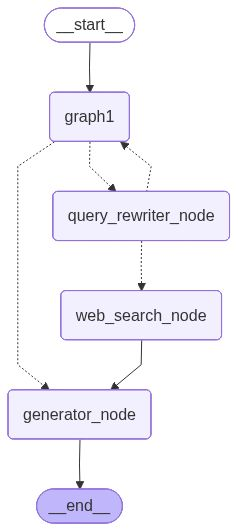

In [105]:
builder2 = StateGraph(cragstate)
builder2.add_node(query_rewriter_node)
builder2.add_node("graph1",graph1)
builder2.add_node(web_search_node)
builder2.add_node(generator_node)


# add edges
builder2.add_edge(START, "graph1")
builder2.add_edge("web_search_node", "generator_node")

# conditional edge for graph1 to query_rewriter_node
def grader_condier(state: cragstate):
    grader_score = state['grader_score']
    if grader_score.lower() == 'no':
        return "query_rewriter_node"
    else:
        return "generator_node"
    
builder2.add_conditional_edges("graph1", grader_condier,{"query_rewriter_node":"query_rewriter_node",
                                                             "generator_node":"generator_node"})

# conditional edge for query_rewriter_node to web_search_node or graph1
def query_rewriter_condition(state: cragstate):
    websearch = state['web_search']
    if websearch:
        return "web_search_node"
    else:
        return "graph1"
builder2.add_conditional_edges("query_rewriter_node", query_rewriter_condition,{"web_search_node":"web_search_node",
                                                                               "graph1":"graph1"})

graph2 = builder2.compile()
graph2




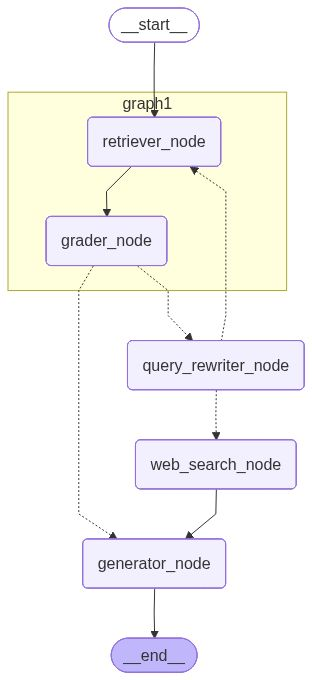

In [106]:
from IPython.display import Image, display
display(Image(graph2.get_graph(xray=True).draw_mermaid_png()))

In [107]:
response = graph2.invoke({"query": "What is the Morningstar Rating for Funds methodology?","refined": False,})
response

=======Retriver with original query =======
=======Grader check=======
=======Answer Generation=======


{'query': 'What is the Morningstar Rating for Funds methodology?',
 'answer': 'The Morningstar Rating™ for Funds, commonly referred to as the "star rating," is a system developed by Morningstar to evaluate mutual funds and other investment products based on their risk-adjusted returns. Here are the key components of the methodology:\n\n1. **Morningstar Categories**: Each fund\'s rating is based on its performance relative to its peers within a specific Morningstar Category, ensuring that funds are compared with valid substitutes in a diversified portfolio rather than across broad asset classes.\n\n2. **Risk-Adjusted Returns**: The star rating evaluates funds based on their risk-adjusted performance. The methodology utilizes metrics such as the Sharpe ratio, which adjusts returns for risk. However, it recognizes that different risk measures can yield varying results, particularly in periods of negative returns, which may not intuitively align with retail investor expectations.\n\n3. **C

In [108]:
response = graph2.invoke({"query": "What is the Morningstar Ratig ?","refined": False,})
response

=======Retriver with original query =======
=======Grader check=======
=======Answer Generation=======


{'query': 'What is the Morningstar Ratig ?',
 'answer': 'The Morningstar Rating, commonly referred to as the "star rating," is a system used by Morningstar to evaluate mutual funds and other investment vehicles based on their risk-adjusted returns. This rating has been in use since 1985 and helps investors and advisors choose funds by comparing them within specific Morningstar Categories rather than across broad asset classes. \n\nThe rating system is designed to group funds into five categories based on their performance, depicted by one to five stars (globes), as follows:\n\n- **High (Top 10%)**: 5 globes\n- **Above Average (Next 22.5%)**: 4 globes\n- **Average (Next 35%)**: 3 globes\n- **Below Average (Next 22.5%)**: 2 globes\n- **Low (Bottom 10%)**: 1 globe\n\nThe rating reflects the funds\' risk-adjusted returns, calculated using various methodologies, including the Sharpe ratio. This approach allows investors to compare funds on a risk-adjusted basis, ensuring that they are makin

In [109]:
response = graph2.invoke({"query": "What is Langchain?","refined": False,"updated_query_web_search":""})
response

=======Retriver with original query =======
=======Grader check=======
=======Query Rewriter with original user query for Retrieval =======
=======Retriver with modified user query =======
=======Grader check=======
=======Query Rewriter with original user query for Web Search =======
=======Web Search =======
=======Answer Generation=======


{'query': 'What is Langchain?',
 'answer': 'LangChain is an open-source framework designed to simplify the creation of applications using large language models (LLMs). It provides developers with tools and components that facilitate the connection of LLMs to various data sources, enabling the development of complex, multi-step workflows. LangChain allows for the orchestration of prompts, making it easier for teams to connect various prompts interactively.\n\nThe framework is available as libraries in Python and JavaScript, and it enhances LLM capabilities beyond mere text generation by linking them to external data and computation. This modular approach enables the breakdown of complex language-based AI systems into reusable components, which can be utilized to build intelligent chatbots, sophisticated question-answering systems, and automated data analysis tools.\n\nLangChain is entirely free to use and open-source, with the source code available on GitHub. It supports integration wit